11/4/2022: script to look at how many new downstream partners are added with each additional sensory neuron. Is there a plateau?

In [1]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
from scipy.optimize import curve_fit

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
    
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [2]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list

FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
allFeCO_ids = FeCO_df['pt_root_id'].to_list()
allFeCO_types = FeCO_df['cell_type'].to_list()

FeCO_dict = dict(zip(allFeCO_ids,allFeCO_types))

syn_threshold = 3; 

In [3]:
#all FeCO neurons
outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)

####filtering based on cells with somas:
soma_df= client.materialize.query_table('somas_dec2022')
soma_ids = soma_df['pt_root_id'].to_list()
outputs = outputs[outputs['post_pt_root_id'].isin(soma_ids)]
#####

syn_per_allFeCOout = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_allFeCOout = syn_per_allFeCOout[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_allFeCOout['number_of_synapses'] > syn_threshold]

#how many combinations are we going to go through?
if math.factorial(len(allFeCO_ids)) >= 50:
    n_samples = 50
else:
    n_samples = math.factorial(len(allFeCO_ids))
    

novel_allFeCOouts = np.zeros((n_samples, len(allFeCO_ids)))
for i in range(n_samples):
    this_combo = np.random.permutation(allFeCO_ids)
        
    for j, allFeCO_id in enumerate(this_combo):
        partners = list(set(syn_per_allFeCOout[syn_per_allFeCOout['pre_pt_root_id']==allFeCO_id]['post_pt_root_id'].tolist()))
        if j == 0:
            novel_allFeCOouts[i, j]=len(partners)
            allallFeCOouts = partners
        else:
            allallFeCOouts = list(set(allallFeCOouts + partners))
            novel_allFeCOouts[i, j] = len(allallFeCOouts)

allFeCO_avgvalues = np.average(novel_allFeCOouts, axis=0)

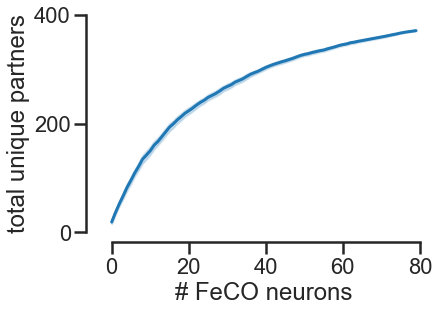

In [4]:
#plot FeCO data

#make a master dataframe with all the data
df = pd.DataFrame(novel_allFeCOouts).melt()
df2 = pd.DataFrame(novel_allFeCOouts, columns=list(range(len(allFeCO_ids))))
df2_transposed = df2.T

sns.set_style("ticks")
sns.set_context("poster")
ytick_fontsize = 20
xtick_fontsize = 20


g = sns.lineplot(data=df, x="variable", y="value")
g.set(xlabel='# FeCO neurons')
g.set(ylabel='total unique partners')
g.set(ylim=(0, 400), yticks=[0, 200, 400])

sns.despine(trim=True, offset=10)

C:\Users\swetarr\anaconda3\envs\connectomics\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


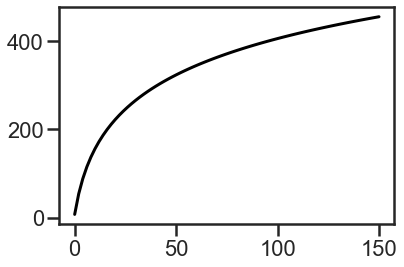

In [5]:
#plot interpolated data as if all FeCO neurons (n=152) had been proofread

def func(x, a, b, c):
  return a*np.log(x + b) + c

x = df["variable"]
y = df["value"]

popt, pcov = curve_fit(func, x, y)

future_days = np.arange(0, 152, 2)


plt.plot( future_days, func(future_days, *popt), '-k')


